In [12]:
%matplotlib inline

In [13]:
import sys
import random
sys.path.append("../")
from ds4400_final_project.dataset.load_gtzan import load_data_from_file
from ds4400_final_project.dataset.common import print_classifier_results
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

The following loads the dataset, as well as dictionaries mapping the genre and its integer encoding (to be used as the ground truths in training and testing the models).

In [14]:
# import the data from the 3 seconds and 30 seconds features CSV
X_3, y_3, index_genre_map_3, genre_index_map_3 = load_data_from_file("features_3_sec.csv")
X_30, y_30, index_genre_map_30, genre_index_map_30 = load_data_from_file("features_30_sec.csv")

The following splits our data into training and testing sets. The data is split 67%/33% between training and testing, and is randomly shuffled.

In [15]:
# split all the data into training and testing sets
TEST_SIZE = 0.33
RANDOM_STATE = 42

torch.manual_seed(RANDOM_STATE)
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

x_3_train, x_3_test, y_3_train, y_3_test = train_test_split(X_3, y_3, test_size=TEST_SIZE, random_state=RANDOM_STATE)
x_30_train, x_30_test, y_30_train, y_30_test = train_test_split(X_30, y_30, test_size=TEST_SIZE, random_state=RANDOM_STATE)

y_3_train, y_3_test, y_30_train, y_30_test = map(torch.LongTensor, [y_3_train, y_3_test, y_30_train, y_30_test])
x_3_train, x_3_test, x_30_train, x_30_test = map(torch.FloatTensor, [x_3_train, x_3_test, x_30_train, x_30_test])


The following blocks define the architectures of the MLP models used for these experiments. `ShallowModel` is a MLP with one hidden layer, while `DeepModelTwoHiddenLayer` and `DeepModelThreeHiddenLayer` define MLPs with two and three hidden layers, respectively.

In [16]:
class ShallowModel(nn.Module):

    def __init__(self, num_hidden: int):
        super().__init__()
        self.hidden = nn.Linear(57, num_hidden)
        self.output = nn.Linear(num_hidden, 10)
        

    def forward(self, x):
        x = torch.relu(self.hidden(x))
        x = self.output(x)
        return x

In [17]:
class DeepModelTwoHiddenLayer(nn.Module):

    def __init__(self, num_hidden_nodes_1: int, num_hidden_nodes_2: int):
        super().__init__()
        self.hidden1 = nn.Linear(57, num_hidden_nodes_1)
        self.hidden2 = nn.Linear(num_hidden_nodes_1, num_hidden_nodes_2)
        self.output = nn.Linear(num_hidden_nodes_2, 10)

    def forward(self, x):
        x = torch.relu(self.hidden1(x))
        x = torch.relu(self.hidden2(x))
        x = self.output(x)
        return x

class DeepModelThreeHiddenLayer(nn.Module):

    def __init__(self, num_hidden_nodes_1: int, num_hidden_nodes_2: int, num_hidden_nodes_3: int):
        super().__init__()
        self.hidden1 = nn.Linear(57, num_hidden_nodes_1)
        self.hidden2 = nn.Linear(num_hidden_nodes_1, num_hidden_nodes_2)
        self.hidden3 = nn.Linear(num_hidden_nodes_2, num_hidden_nodes_3)
        self.output = nn.Linear(num_hidden_nodes_3, 10)

    def forward(self, x):
        x = torch.relu(self.hidden1(x))
        x = torch.relu(self.hidden2(x))
        x = torch.relu(self.hidden3(x))
        x = self.output(x)
        return x

The following defines a PyTorch `Dataset` that enables us to use PyTorch's `DataLoader` class for batching.

In [18]:
class GTZANDataset(Dataset):

    def __init__(self, x_data, y_data):
        self._x_data = x_data
        self._y_data = y_data

    def __len__(self):
        return len(self._x_data)
        
    def __getitem__(self, idx):
        return [self._x_data[idx], self._y_data[idx]]

The following defines a function for training a model instance.

In [19]:
def train_model(model, loss_func, x_train, y_train, epochs: int, lr: float, l2_reg: float, batch_size: int, verbose = False):
	dataset = GTZANDataset(x_train, y_train)
	dataloader = DataLoader(dataset, batch_size=batch_size)

	# set the model to training mode
	model.train()

	# save average losses every epoch
	losses = []

	# optimize the model
	for epoch in range(epochs):

		optimizer = torch.optim.SGD(params=model.parameters(), lr=lr, weight_decay=l2_reg)

		losses_each_batch = []

		for batch, (x, y) in enumerate(dataloader):

			y_pred = model(x)

			loss = loss_func(y_pred, y)

			# backpropogation
			optimizer.zero_grad()
			loss.backward()
			optimizer.step()

			with torch.no_grad():
				for param in model.parameters():
					param -= lr * param.grad

			# save the loss for this batch
			losses_each_batch.append(loss.item())

			if verbose and batch % (batch_size // 10) == 0:
				avg_running_loss = sum(losses_each_batch) / len(losses_each_batch)
				current = batch * len(x)
				# print(f"Epoch [{epoch:03}] Batch [{batch:03}] avg_running_loss: {avg_running_loss:>7f} [{current:>5d}/{len(dataset):>5d}]")

		# average all the batch losses for this epoch and save it
		avg_loss_epoch = sum(losses_each_batch) / len(losses_each_batch)
		losses.append(avg_loss_epoch)

		if verbose and (epoch % 50 == 0):
			print(f"Epoch [{epoch:03}]: average loss: {avg_loss_epoch:>7f}")

	# set the model to evaluation mode
	model.eval()
	return model, losses

The following function enables us to run multiple different experiments in a single function call. The experiments are configured using Python dictionaries defining:
* The model class
* Arguments for the model class's constructor
* The loss function class
* Arguments for the loss function class's constructor
* The number of epochs
* The learning rate
* The rate for L2 regularization
* The batch size
* A verbose option for printing the loss during training

In [20]:
def run_training_experiments(experiment_configs, x_train, y_train):

    models = {}

    for model_id, config in experiment_configs.items():
        model_class = config["model_class"]
        model_kwargs = config["model_kwargs"] if "model_kwargs" in config.keys() else {} 
        model_instance = model_class(**model_kwargs)
        loss_func_class = config["loss_func_class"]
        loss_func_kwargs = config["loss_func_kwargs"] if "loss_func_kwargs" in config.keys() else {}
        loss_func = loss_func_class(**loss_func_kwargs)

        print(f"TRAINING MODEL: {model_id}")

        output_model, losses = train_model(
            model=model_instance,
            loss_func=loss_func,
            x_train=x_train,
            y_train=y_train,
            epochs=config["epoch"],
            lr=config["lr"],
            l2_reg=config["l2_reg"],
            batch_size=config["batch_size"],
            verbose=config["verbose"]
        )

        models[model_id] = {"model": output_model, "losses": losses}

    return models


The following code block runs multiple experiments on various learning rates. This might take about 15 - 20 minutes

In [21]:
EPOCHS = 1000
L2_REGULARIZATION = 0.0001
BATCH_SIZE = 128

lr_experiment_dict_3_sec = {}
lr_experiment_dict_30_sec = {}

for lr in [0.1, 0.01, 0.001]:
    print(f"EVALUATING ON LEARNING RATE = {lr}")
    print("------------------------------------")
    experiments = {
        "1 Hidden Layer, 32 Nodes": {
            "model_class": ShallowModel,
            "model_kwargs": {
                "num_hidden": 32
            },
            "loss_func_class": nn.CrossEntropyLoss,
            "epoch": EPOCHS,
            "lr": lr,
            "l2_reg": L2_REGULARIZATION,
            "batch_size": BATCH_SIZE,
            "verbose": True
        },
        "1 Hidden Layer, 64 Nodes": {
            "model_class": ShallowModel,
            "model_kwargs": {
                "num_hidden": 64
            },
            "loss_func_class": nn.CrossEntropyLoss,
            "epoch": EPOCHS,
            "lr": lr,
            "l2_reg": L2_REGULARIZATION,
            "batch_size": BATCH_SIZE,
            "verbose": True
        },
        "1 Hidden Layer, 128 Nodes": {
            "model_class": ShallowModel,
            "model_kwargs": {
                "num_hidden": 128
            },
            "loss_func_class": nn.CrossEntropyLoss,
            "epoch": EPOCHS,
            "lr": lr,
            "l2_reg": L2_REGULARIZATION,
            "batch_size": BATCH_SIZE,
            "verbose": True
        },
        "2 Hidden Layers, 64 and 32 nodes": {
            "model_class": DeepModelTwoHiddenLayer,
            "model_kwargs": {
                "num_hidden_nodes_1": 64,
                "num_hidden_nodes_2": 32
            },
            "loss_func_class": nn.CrossEntropyLoss,
            "epoch": EPOCHS,
            "lr": lr,
            "l2_reg": L2_REGULARIZATION,
            "batch_size": BATCH_SIZE,
            "verbose": True
        },
        "2 Hidden Layers, 128 and 64 nodes": {
            "model_class": DeepModelTwoHiddenLayer,
            "model_kwargs": {
                "num_hidden_nodes_1": 128,
                "num_hidden_nodes_2": 64
            },
            "loss_func_class": nn.CrossEntropyLoss,
            "epoch": EPOCHS,
            "lr": lr,
            "l2_reg": L2_REGULARIZATION,
            "batch_size": BATCH_SIZE,
            "verbose": True
        },
        "3 Hidden Layers, 128, 64, and 32 Nodes": {
            "model_class": DeepModelThreeHiddenLayer,
            "model_kwargs": {
                "num_hidden_nodes_1": 128,
                "num_hidden_nodes_2": 64,
                "num_hidden_nodes_3": 32
            },
            "loss_func_class": nn.CrossEntropyLoss,
            "epoch": EPOCHS,
            "lr": lr,
            "l2_reg": L2_REGULARIZATION,
            "batch_size": BATCH_SIZE,
            "verbose": True
        }
    }

    three_sec_training_results = run_training_experiments(experiment_configs=experiments, x_train=x_3_train, y_train=y_3_train)
    thirty_sec_training_results = run_training_experiments(experiment_configs=experiments, x_train=x_30_train, y_train=y_30_train)
    lr_experiment_dict_3_sec[str(lr)] = three_sec_training_results
    lr_experiment_dict_30_sec[str(lr)] = thirty_sec_training_results

EVALUATING ON LEARNING RATE = 0.1
------------------------------------
TRAINING MODEL: 1 Hidden Layer, 32 Nodes
Epoch [000]: average loss: 1.682011
Epoch [050]: average loss: 0.362680
Epoch [100]: average loss: 0.271395
Epoch [150]: average loss: 0.228993
Epoch [200]: average loss: 0.199930
Epoch [250]: average loss: 0.177991
Epoch [300]: average loss: 0.160585
Epoch [350]: average loss: 0.147841
Epoch [400]: average loss: 0.136444
Epoch [450]: average loss: 0.127003
Epoch [500]: average loss: 0.118578
Epoch [550]: average loss: 0.111699
Epoch [600]: average loss: 0.105406
Epoch [650]: average loss: 0.100128
Epoch [700]: average loss: 0.095638
Epoch [750]: average loss: 0.091678
Epoch [800]: average loss: 0.086407
Epoch [850]: average loss: 0.082067
Epoch [900]: average loss: 0.078440
Epoch [950]: average loss: 0.074144
TRAINING MODEL: 1 Hidden Layer, 64 Nodes
Epoch [000]: average loss: 1.624324
Epoch [050]: average loss: 0.210862
Epoch [100]: average loss: 0.092079
Epoch [150]: averag

The following evaluates the the model on the given data and reports its accuracy. It also reports the number of times it correctly classifies a specific genre.

In [22]:
def evaluate_model(model, x_data, y_data, batch_size):
	dataset = GTZANDataset(x_data, y_data)
	dataloader = DataLoader(dataset, batch_size=batch_size)

	model.eval()

	correct = 0
	pred = 0

	correct_by_classes = {genre: {"correct":  0, "total": 0} for genre in genre_index_map_3.keys()}
    
	for x, y in dataloader:
		y_pred = model(x)

		y_pred_softmax = torch.log_softmax(y_pred, dim=1)
		_, y_pred_tags = torch.max(y_pred_softmax, dim=1)

		correct_pred = (y_pred_tags == y).float()

		for i, prediction in enumerate(correct_pred):
			label = index_genre_map_3[y[i].item()]
			if prediction > 0.5:
				correct_by_classes[label]["correct"] += 1
			correct_by_classes[label]["total"] += 1
		correct += int(correct_pred.sum())
		pred += len(correct_pred)

	acc = correct / pred
	return acc, correct_by_classes

In [23]:
def plot_loss(outputs, title):
    # plt.figure(figsize=(15, 15))
    legend = []
    for model_id, output in outputs.items():
        legend.append(model_id)
        losses = output["losses"]
        plt.plot(range(len(losses)), losses)
    plt.legend(legend, loc='upper left')
    plt.xlabel("Epoch")
    plt.ylabel("Loss Score")
    # plt.ylim([0.0, 0.5])
    plt.title(title)
    plt.show()

In [24]:
def plot_accuracy_bar_chart(accuracies, title):

    # plt.figure(figsize=(14, 14))
    labels = list(accuracies.keys())
    formatted_labels = []
    for label in labels:
        comma_idx = label.index(",")
        formatted_labels.append(label[:comma_idx + 1] + "\n" + label[comma_idx+2:])
    
    train_accuracies = [accuracies[labels[i]]["train"] for i in range(len(labels))]
    test_accuracies = [accuracies[labels[i]]["test"] for i in range(len(labels))]
    N = len(labels)
    indices = np.arange(N)
    width = 0.35
    plt.bar(indices, train_accuracies, width, label="Training Accuracy")
    plt.bar(indices, test_accuracies, width, label="Testing Accuracy")

    plt.ylabel("Accuracy (%)")
    plt.xlabel("Model")
    plt.title(title)

    plt.xticks(
        indices + width / 2,
        formatted_labels,
        rotation=45,
        horizontalalignment='right',
        fontweight='light',
        fontsize='small'  
    )

    plt.legend(loc="upper left")
    plt.show()

In [25]:
def get_best_performing_learning_rate(experiment_dict, x_test, y_test):
    best_lr = None
    best_avg_acc = None

    for lr, experiments in experiment_dict.items():
        test_accuracy = []
        for result in experiments.values():
            model = result["model"]
            test_acc, _ = evaluate_model(model, x_test, y_test, batch_size=1)
            test_accuracy.append(test_acc)
        avg_acc = sum(test_accuracy) / len(test_accuracy)
        if best_lr is None:
            best_lr = lr
            best_avg_acc = avg_acc
        elif avg_acc > best_avg_acc:
            best_lr = lr
            best_avg_acc = avg_acc

    return best_lr

In [26]:
best_3_sec_lr = str(get_best_performing_learning_rate(lr_experiment_dict_3_sec, x_3_test, y_3_test))
best_30_sec_lr = str(get_best_performing_learning_rate(lr_experiment_dict_30_sec, x_30_test, y_30_test))

best_3_sec_experiments = lr_experiment_dict_3_sec[best_3_sec_lr]
best_30_sec_experiments = lr_experiment_dict_30_sec[best_30_sec_lr]

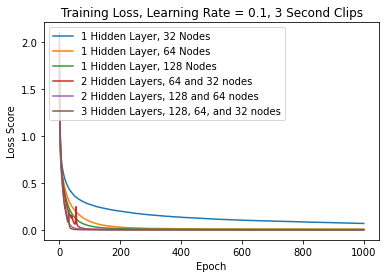

In [27]:
plot_loss(best_3_sec_experiments, f"Training Loss, Learning Rate = {best_3_sec_lr}, 3 Second Clips")

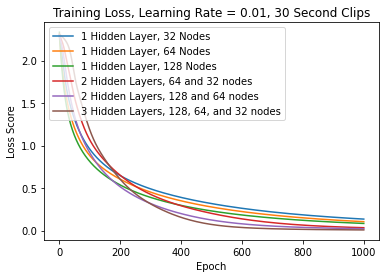

In [28]:
plot_loss(best_30_sec_experiments, f"Training Loss, Learning Rate = {best_30_sec_lr}, 30 Second Clips")

In [29]:
def get_accuracies(experiments, x_train, y_train, x_test, y_test):
    accuracies = {}
    for title, result in experiments.items():
        model = result["model"]
        train_acc, correct_by_training_classes = evaluate_model(model, x_train, y_train, batch_size=BATCH_SIZE)
        test_acc, correct_by_test_classes = evaluate_model(model, x_test, y_test, batch_size=BATCH_SIZE)
        accuracies[title] = {"train": train_acc, "test": test_acc, "class_scores_train": correct_by_training_classes, "class_scores_test": correct_by_test_classes}

    return accuracies

three_sec_accuracies = get_accuracies(best_3_sec_experiments, x_train=x_3_train, y_train=y_3_train, x_test=x_3_test, y_test=y_3_test)
thirty_sec_accuracies = get_accuracies(best_30_sec_experiments, x_train=x_30_train, y_train=y_30_train, x_test=x_30_test, y_test=y_30_test)

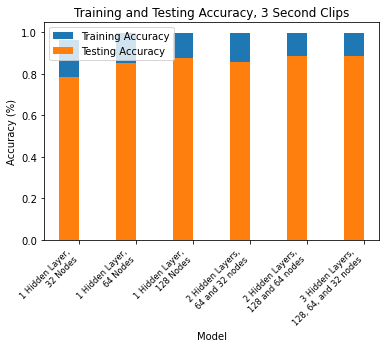

In [30]:
plot_accuracy_bar_chart(three_sec_accuracies, "Training and Testing Accuracy, 3 Second Clips")

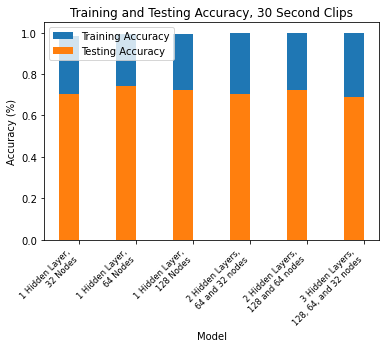

In [31]:
plot_accuracy_bar_chart(thirty_sec_accuracies, "Training and Testing Accuracy, 30 Second Clips")

In [40]:
def print_class_results(accuracy_results, title):

    train_accuracy = accuracy_results["train"]
    test_accuracy = accuracy_results["test"]

    failed_count = {}
    for genre, correct_trained_counts in accuracy_results["class_scores_train"].items():
        failed_count[genre] = correct_trained_counts["total"] - correct_trained_counts["correct"]
    for genre, correct_test_counts in accuracy_results["class_scores_test"].items():
        failed_count[genre] += (correct_test_counts["total"] - correct_test_counts["correct"])
        
    print_classifier_results(
        title=title,
        train_accuracy=train_accuracy,
        test_accuracy=test_accuracy,
        failed_count=failed_count
    )

In [41]:
for title, accuracy_obj in three_sec_accuracies.items():
    print_class_results(accuracy_obj, title)

1 Hidden Layer, 32 Nodes
Train accuracy: 96.25%
Train error:    3.75%
Test accuracy:  78.53%
Test error:     21.47%

| #   | Genre      | # of Incorrect | % of All Incorrect |
| --- |    ---     |      ---       |        ---         |
| 01  | COUNTRY    | 166            | 17.3%              |
| 02  | ROCK       | 161            | 16.8%              |
| 03  | DISCO      | 143            | 14.9%              |
| 04  | REGGAE     | 113            | 11.8%              |
| 05  | BLUES      | 97             | 10.1%              |
| 06  | CLASSICAL  | 83             | 8.7%               |
| 07  | HIPHOP     | 64             | 6.7%               |
| 08  | POP        | 52             | 5.4%               |
| 09  | JAZZ       | 49             | 5.1%               |
| 10  | METAL      | 31             | 3.2%               |
1 Hidden Layer, 64 Nodes
Train accuracy: 99.9%
Train error:    0.1%
Test accuracy:  85.5%
Test error:     14.5%

| #   | Genre      | # of Incorrect | % of All Incorrect |
| -

In [43]:
for title, accuracy_obj in thirty_sec_accuracies.items():
    print_class_results(accuracy_obj, title)

1 Hidden Layer, 32 Nodes
Train accuracy: 98.21%
Train error:    1.79%
Test accuracy:  70.3%
Test error:     29.7%

| #   | Genre      | # of Incorrect | % of All Incorrect |
| --- |    ---     |      ---       |        ---         |
| 01  | REGGAE     | 19             | 17.3%              |
| 02  | ROCK       | 18             | 16.4%              |
| 03  | DISCO      | 15             | 13.6%              |
| 04  | HIPHOP     | 14             | 12.7%              |
| 05  | JAZZ       | 12             | 10.9%              |
| 06  | BLUES      | 10             | 9.1%               |
| 07  | COUNTRY    | 10             | 9.1%               |
| 08  | POP        | 9              | 8.2%               |
| 09  | METAL      | 2              | 1.8%               |
| 10  | CLASSICAL  | 1              | 0.9%               |
1 Hidden Layer, 64 Nodes
Train accuracy: 99.25%
Train error:    0.75%
Test accuracy:  74.24%
Test error:     25.76%

| #   | Genre      | # of Incorrect | % of All Incorrect |
|